In [1]:
from src.models import Exponential_Model
from src.criterion import right_censored,RightCensorWrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

from tqdm import tqdm
import pandas as pd
import numpy as np

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
dataset_train,dataset_test = load_datasets("TRACE",test_size=0.2)

In [3]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1
hidden_dim = [15,15]
batch_size = 32
print_every = 50
lr = 1e-5

In [4]:
dataloader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [5]:
clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)

optimizer = Adam(clf.parameters(),lr=1e-3)
criterion = right_censored

In [6]:
epochs,train_loss = train(model=clf,dataloader_train=dataloader_train,optimizer=optimizer,criterion=criterion,print_every=print_every,epochs=200)

Epoch 50, LL=2059.574
Epoch 100, LL=2030.470
Epoch 150, LL=2013.497
Epoch 200, LL=1995.296
Finished Training


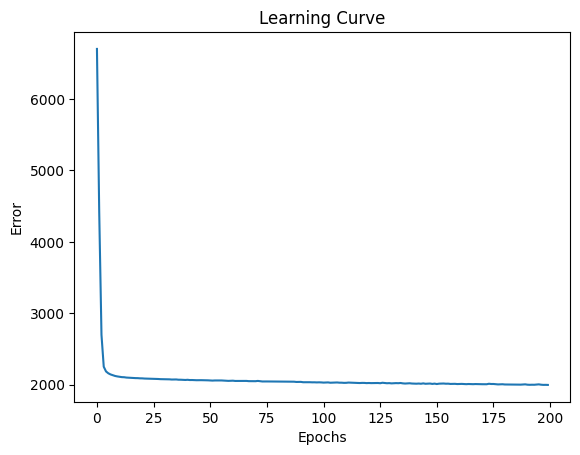

In [7]:
plt.plot(epochs,train_loss)
plt.ylabel("Error"); plt.xlabel("Epochs")
plt.title("Learning Curve")
plt.show()

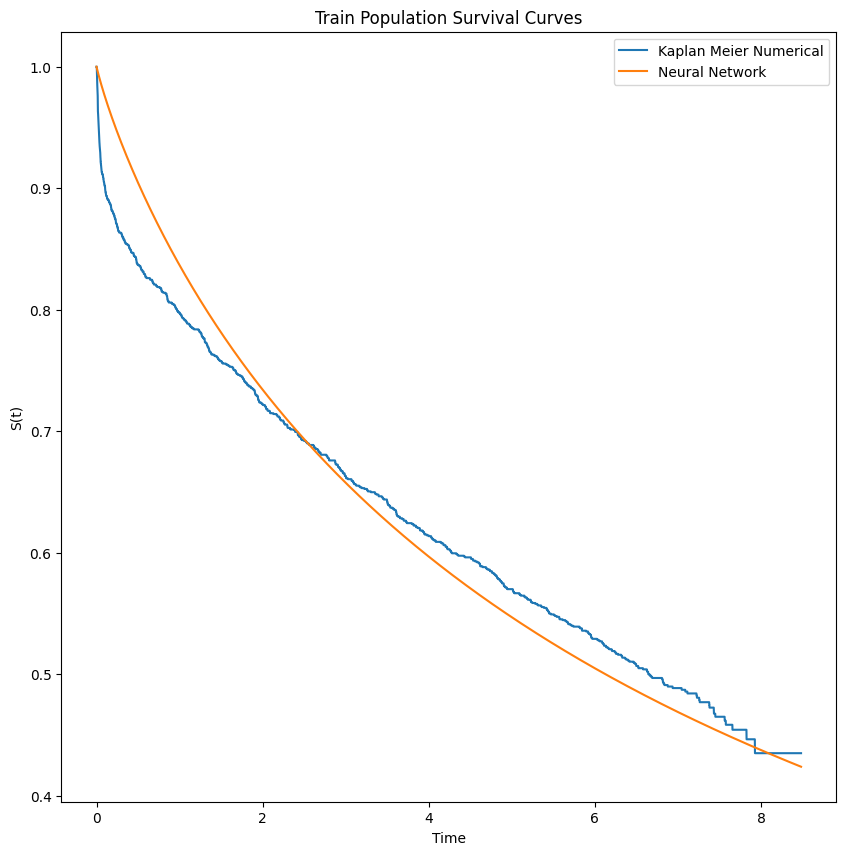

In [8]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network"])
plt.title("Train Population Survival Curves")
plt.show()

## AUTO LIRPA 

In [9]:
# model = BoundedModule(loss_clf, (X_train,T_train,E_train))
# # Define perturbation. Here we add Linf perturbation to input data.
# ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# # Make the input a BoundedTensor with the pre-defined perturbation.
# my_input = BoundedTensor(torch.Tensor(X_train), ptb)
# # Regular forward propagation using BoundedTensor works as usual.
# prediction = model(my_input,T_train,E_train)
# # Compute LiRPA bounds using CROWN
# lb, ub = model.compute_bounds(x=(my_input,T_train,E_train), method="backward")

In [10]:
# model = BoundedModule(loss_clf, (X_train,T_train,E_train))
# # Define perturbation. Here we add Linf perturbation to input data.
# ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# # Make the input a BoundedTensor with the pre-defined perturbation.
# my_input = BoundedTensor(torch.Tensor(X_train), ptb)
# # Regular forward propagation using BoundedTensor works as usual.
# # prediction = model(my_input,T_train,E_train)
# # Compute LiRPA bounds using CROWN
# lb, ub = model.compute_bounds(x=(my_input,T_train,E_train), method="backward",bound_upper=False)

In [11]:
"""
A simple script to train certified defense using the auto_LiRPA library.

We compute output bounds under input perturbations using auto_LiRPA, and use
them to form a "robust loss" for certified defense.  Several different bound
options are supported, such as IBP, CROWN, and CROWN-IBP. This is a basic
example on MNIST and CIFAR-10 datasets with Lp (p>=0) norm perturbation. For
faster training, please see our examples with loss fusion such as
cifar_training.py and tinyimagenet_training.py
"""

import time
import random
import multiprocessing
import argparse
import torch.optim as optim
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *
from auto_LiRPA.utils import MultiAverageMeter
from auto_LiRPA.eps_scheduler import LinearScheduler, AdaptiveScheduler, SmoothedScheduler, FixedScheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms



def Train(model_loss, t, loader, eps_scheduler, norm, train, opt, bound_type, method='robust'):
    meter = MultiAverageMeter()
    if train:
        model_loss.train()
        eps_scheduler.train()
        eps_scheduler.step_epoch()
        eps_scheduler.set_epoch_length(int((len(loader.dataset) + loader.batch_size - 1) / loader.batch_size))
    else:
        model_loss.eval()
        eps_scheduler.eval()

    for i, data in enumerate(loader):
        start = time.time()
        eps_scheduler.step_batch()
        eps = eps_scheduler.get_eps()
        xi,ti,yi = data

        # For small eps just use natural training, no need to compute LiRPA bounds
        batch_method = method
        if eps < 1e-20:
            batch_method = "natural"
        if train:
            opt.zero_grad()

        # ptb = PerturbationLpNorm(norm=norm, eps=torch.Tensor([epsilon]))


        # Specify Lp norm perturbation.
        # When using Linf perturbation, we manually set element-wise bound x_L and x_U. eps is not used for Linf norm.
        if norm > 0:
            ptb = PerturbationLpNorm(norm=norm, eps=eps)
        elif norm == 0:
            ptb = PerturbationL0Norm(eps = eps_scheduler.get_max_eps(), ratio = eps_scheduler.get_eps()/eps_scheduler.get_max_eps())
        
        # Make the input a BoundedTensor with the pre-defined perturbation.
        x_bounded = BoundedTensor(xi, ptb)

        regular_loss = model_loss(xi,ti,yi).sum() # regular Right Censoring
        meter.update('Loss', regular_loss.item(), xi.size(0))
        if batch_method == "robust":
            # Compute LiRPA bounds using CROWN
            lb, ub = model_loss.compute_bounds(x=(x_bounded,ti,yi), method="backward",bound_upper=True,bound_lower=False)
            robust_loss = ub.sum()
            loss = robust_loss
        elif batch_method == "natural":
            loss =  regular_loss
        if train:
            (.1*loss+0.9*regular_loss).backward()
            eps_scheduler.update_loss(loss.item() - regular_loss.item())
            opt.step()
        meter.update('Loss', loss.item(), xi.size(0))
        if batch_method != "natural":
            meter.update('Robust_Loss', robust_loss.item(), xi.size(0))

        meter.update('Time', time.time() - start)
        if i % 10 == 0 and train:
            print('[{:2d}:{:4d}]: eps={:.8f} {}'.format(t, i, eps, meter))
    print('[{:2d}:{:4d}]: eps={:.8f} {}'.format(t, i, eps, meter))



C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [12]:
class ARGS(object):
    def __init__(self):
        pass

In [13]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.3
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=15
args.lr = 1e-3
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=5,length=10"
args.save_model = "apple.pth"


In [14]:
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)
clf_fragile.load_state_dict(clf.state_dict())

<All keys matched successfully>

In [15]:
# model = BoundedModule(clf, X_train)
loss_clf = RightCensorWrapper(clf)
X_train,T_train,E_train = dataloader_train.dataset.tensors
model_loss = BoundedModule(loss_clf, (X_train,T_train,E_train))


In [16]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)


## Step 4 prepare optimizer, epsilon scheduler and learning rate scheduler
opt = optim.Adam(model_loss.parameters(), lr=args.lr)
norm = float(args.norm)
lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
eps_scheduler = eval(args.scheduler_name)(args.eps, args.scheduler_opts)
print("Model structure: \n", str(clf))

## Step 5: start training
if args.verify:
    eps_scheduler = FixedScheduler(args.eps)
    with torch.no_grad():
        Train(model, 1, test_data, eps_scheduler, norm, False, None, args.bound_type)
else:
    timer = 0.0
    for t in range(1, args.num_epochs+1):
        if eps_scheduler.reached_max_eps():
            # Only decay learning rate after reaching the maximum eps
            lr_scheduler.step()
        print("Epoch {}, learning rate {}".format(t, lr_scheduler.get_lr()))
        start_time = time.time()
        Train(model_loss, t, dataloader_train, eps_scheduler, norm, True, opt, args.bound_type)
        epoch_time = time.time() - start_time
        timer += epoch_time
        print('Epoch time: {:.4f}, Total time: {:.4f}'.format(epoch_time, timer))
        print("Evaluating...")
        with torch.no_grad():
            Train(model_loss, t, dataloader_test, eps_scheduler, norm, False, None, args.bound_type)
        torch.save({'state_dict': loss_clf.state_dict(), 'epoch': t}, args.save_model if args.save_model != "" else args.model)

Model structure: 
 Exponential_Model(
  (linears): ModuleList(
    (0): Linear(in_features=10, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=15, bias=True)
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)
Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=37.4078 Time=0.0020
[ 1:  10]: eps=0.00000000 Loss=41.6290 Time=0.0017
[ 1:  20]: eps=0.00000000 Loss=42.7970 Time=0.0019
[ 1:  30]: eps=0.00000000 Loss=42.6540 Time=0.0018
[ 1:  40]: eps=0.00000000 Loss=42.8578 Time=0.0018
[ 1:  46]: eps=0.00000000 Loss=42.5648 Time=0.0018
Epoch time: 0.0903, Total time: 0.0903
Evaluating...
[ 1:  11]: eps=0.00000000 Loss=46.6149 Time=0.0011
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=47.0849 Time=0.0020
[ 2:  10]: eps=0.00000000 Loss=43.6214 Time=0.0020
[ 2:  20]: eps=0.00000000 Loss=42.5300 Time=0.0021
[ 2:  30]: eps=0.00000000 Loss=42.3280 Time=0.0019
[ 2:  40]: eps=0.00000000 Loss=42.3925 Time=0.0019


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


[ 2:  46]: eps=0.00000000 Loss=42.4779 Time=0.0019
Epoch time: 0.1004, Total time: 0.1907
Evaluating...
[ 2:  11]: eps=0.00000000 Loss=46.7491 Time=0.0012
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=43.8475 Time=0.0020
[ 3:  10]: eps=0.00000000 Loss=42.1821 Time=0.0025
[ 3:  20]: eps=0.00000000 Loss=43.8350 Time=0.0022
[ 3:  30]: eps=0.00000000 Loss=42.5421 Time=0.0021
[ 3:  40]: eps=0.00000000 Loss=42.1467 Time=0.0021
[ 3:  46]: eps=0.00000000 Loss=42.4998 Time=0.0020
Epoch time: 0.1047, Total time: 0.2954
Evaluating...
[ 3:  11]: eps=0.00000000 Loss=46.7655 Time=0.0021
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=50.8167 Time=0.0061
[ 4:  10]: eps=0.00000000 Loss=42.0294 Time=0.0024
[ 4:  20]: eps=0.00000000 Loss=42.6117 Time=0.0022
[ 4:  30]: eps=0.00000000 Loss=42.5021 Time=0.0023
[ 4:  40]: eps=0.00000000 Loss=42.4400 Time=0.0022
[ 4:  46]: eps=0.00000000 Loss=42.4544 Time=0.0021
Epoch time: 0.1123, Total time: 0.4077
Evaluating...
[ 4:  11]: eps

In [17]:
import re

In [18]:
robust_clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dim,output_dim=output_dim)
robust_clf.load_state_dict({re.sub("model.","",key):value for key,value in model_loss.state_dict().items()})

<All keys matched successfully>

In [19]:
def lower_bound(clf,nominal_input,epsilon):
    # Wrap the model with auto_LiRPA.
    model = BoundedModule(clf, nominal_input)
    # Define perturbation. Here we add Linf perturbation to input data.
    ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
    # Make the input a BoundedTensor with the pre-defined perturbation.
    my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
    # Regular forward propagation using BoundedTensor works as usual.
    prediction = model(my_input)
    # Compute LiRPA bounds using CROWN
    lb, ub = model.compute_bounds(x=(my_input,), method="backward")
    
    return lb,ub

==========@ eps=0.5==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.7373723804406234
==========@ eps=0.1==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.754144037383895
==========@ eps=0.07==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.7535395236815844
==========@ eps=0.05==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.7532408651262762
==========@ eps=0.03==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.7531593037537422
==========@ eps=0.01==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.7528798361096185
==========@ eps=0.001==========
Train CI Unperturbed 0.7528030724648807
Train CI Pertubed 0.7528150667843709


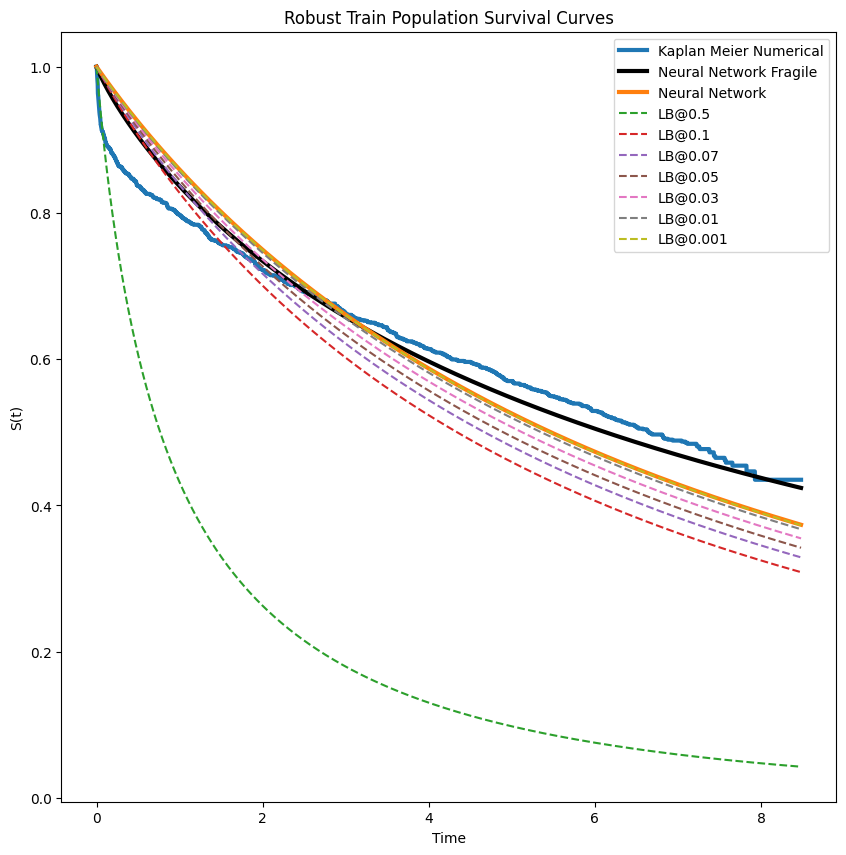

In [20]:
plt.figure(figsize=(10,10))
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_fragile_given_x = clf_fragile.survival_qdf(X_train,t).detach()
St_given_x = clf.survival_qdf(X_train,t).detach()
kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf = kmf.predict(times=t.ravel().numpy())

plt.plot(t,St_kmf,linewidth=3)
plt.plot(t,St_fragile_given_x.mean(0),'k-',linewidth=3)
plt.plot(t,St_given_x.mean(0),linewidth=3)

epsilons = [0.5,0.1,0.07,0.05,0.03,0.01,0.001]
for epsilon in epsilons:
    lb,ub = lower_bound(robust_clf,X_train,epsilon)
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Train CI Unperturbed",concordance_index(event_times=T_train,predicted_scores=-robust_clf.rate_logit(X_train).detach(),event_observed=E_train))
    print("Train CI Pertubed",concordance_index(event_times=T_train,predicted_scores=-ub.detach(),event_observed=E_train))
    plt.plot(t,St_lb.detach(),'--')



plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network Fragile","Neural Network"]+[f"LB@{epsilon}" for epsilon in epsilons])
plt.title("Robust Train Population Survival Curves")
plt.show()

==========@ eps=0.5==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.6935362220462344
==========@ eps=0.1==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.7109778632575329
==========@ eps=0.07==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.7109401516008598
==========@ eps=0.05==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.7108930120300185
==========@ eps=0.03==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.7103367650940906
==========@ eps=0.01==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.7102047742957348
==========@ eps=0.001==========
Train CI Unperturbed 0.710072783497379
Train CI Pertubed 0.7100916393257156


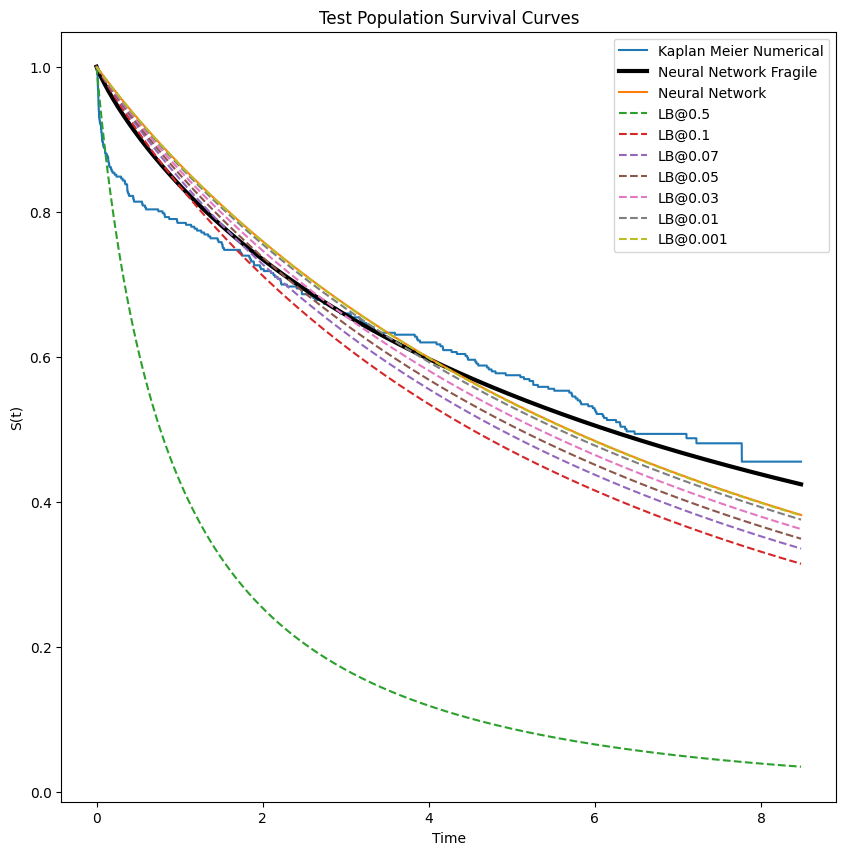

In [21]:
plt.figure(figsize=(10,10))
X_test,T_test,E_test = dataloader_test.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

St_given_x = clf.survival_qdf(X_test,t).detach()
St_fragile_given_x = clf_fragile.survival_qdf(X_train,t).detach()
kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kmf.predict(times=t.ravel().numpy())

plt.plot(t,St_kmf)
plt.plot(t,St_fragile_given_x.mean(0),'k-',linewidth=3)
plt.plot(t,St_given_x.mean(0))

epsilons = [0.5,0.1,0.07,0.05,0.03,0.01,0.001]
for epsilon in epsilons:
    lb,ub = lower_bound(robust_clf,X_test,epsilon)
    St_lb = torch.exp(-ub*t).mean(0)
    print("="*10 + "@ eps={}".format(epsilon) + "="*10)
    print("Train CI Unperturbed",concordance_index(event_times=T_test,predicted_scores=-clf.rate_logit(X_test).detach(),event_observed=E_test))
    print("Train CI Pertubed",concordance_index(event_times=T_test,predicted_scores=-ub.detach(),event_observed=E_test))
    plt.plot(t,St_lb.detach(),'--')


plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network Fragile","Neural Network"]+[f"LB@{epsilon}" for epsilon in epsilons])
plt.title("Test Population Survival Curves")
plt.show()

In [22]:
lb,ub = lower_bound(robust_clf,X_test,0.1)
St_lb = torch.exp(-ub*t).detach()

tensor([2.4200, 2.8175, 3.0298, 3.1794, 3.1829, 3.1873, 3.1954, 3.4050, 3.5447,
        3.6896, 3.7599, 3.7611, 3.7814, 3.8249, 3.9601, 3.9825, 4.0479, 4.0536,
        4.0743, 4.0764, 4.0769, 4.0813, 4.0845, 4.0869, 4.0935, 4.1092, 4.1114,
        4.1138, 4.1152, 4.1205])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.89it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

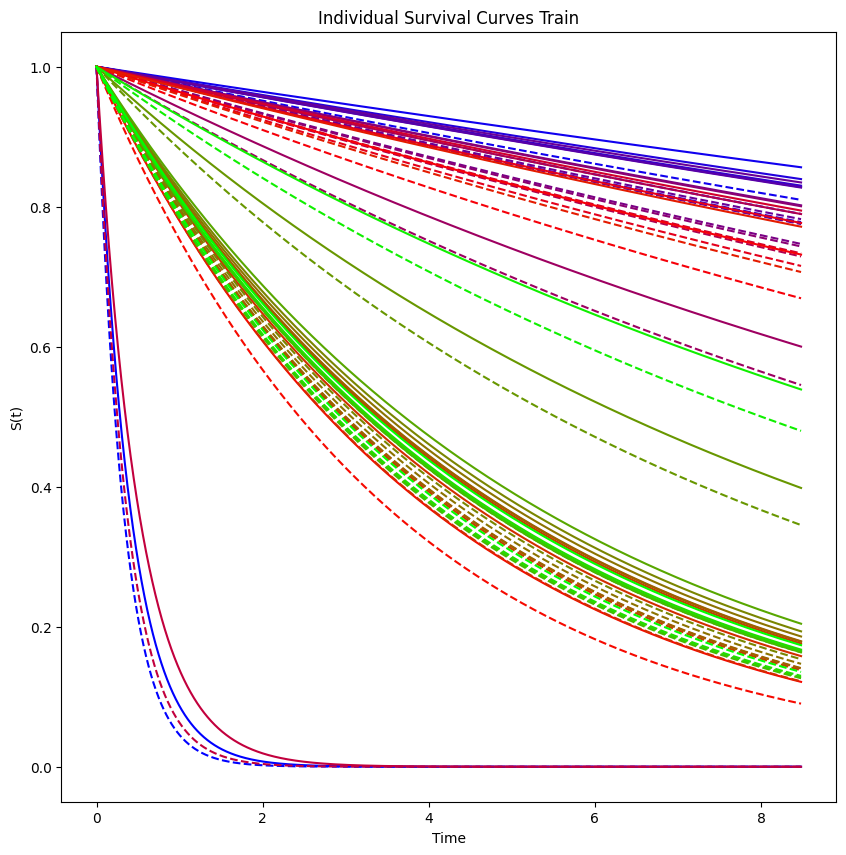

In [23]:
plt.figure(figsize=(10,10))

    
test_cases = 30

colors = list(plt.cm.brg(np.linspace(0,1,test_cases))) + ["crimson", "indigo"]

cases = np.argsort(torch.linalg.norm(St_lb - St_given_x,axis=1))[0:test_cases]
print(torch.linalg.norm(St_lb - St_given_x,axis=1)[cases])

for i,case in enumerate(tqdm(cases)):
    plt.plot(t,St_given_x[case],color=colors[i])
    plt.plot(t,St_lb[case],'--',color=colors[i])
    
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")

tensor([13.1782, 12.1136, 12.0742, 11.5256, 11.4321, 11.2668, 11.2505, 10.6298,
        10.1526,  9.7663,  9.6705,  9.5860,  9.4558,  9.3677,  9.0895,  9.0880,
         8.9533,  8.9389,  8.9113,  8.7211,  8.7031,  8.6614,  8.4324,  8.4304,
         8.4197,  8.4112,  8.4029,  8.3988,  8.3539,  8.3220])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.70it/s]


Text(0.5, 1.0, 'Individual Survival Curves Train')

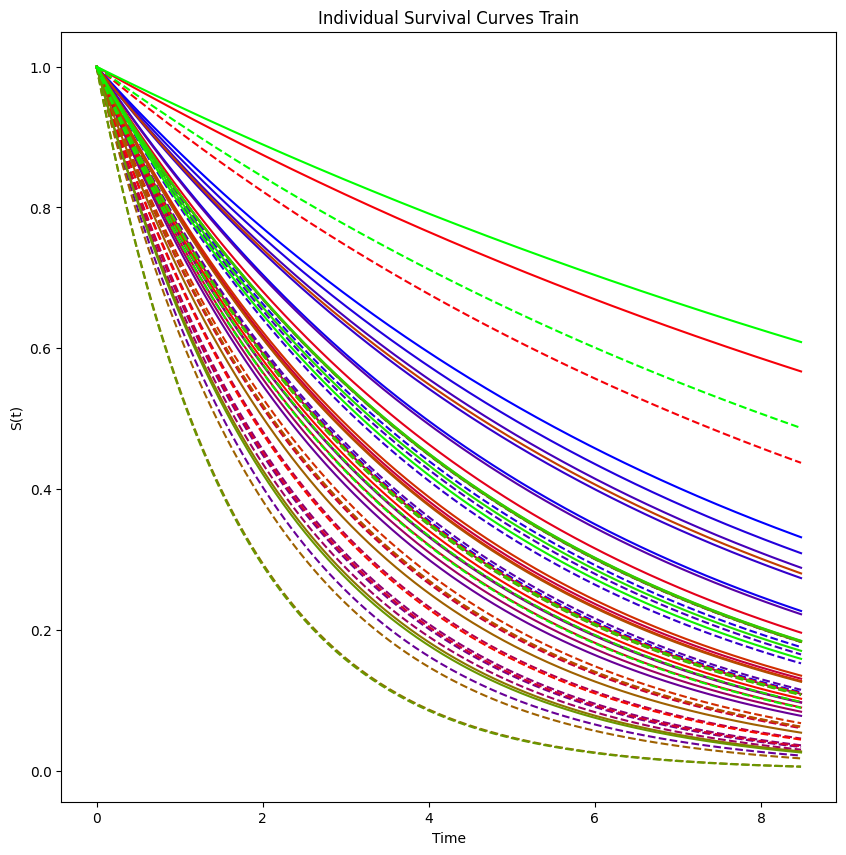

In [24]:
plt.figure(figsize=(10,10))
# lb,ub = lower_bound(model,X_train,0.1)
    
test_cases = 30
cases = torch.flip(np.argsort(torch.linalg.norm(St_lb - St_given_x,axis=1)),dims=(0,))[0:test_cases]
print(torch.linalg.norm(St_lb - St_given_x,axis=1)[cases])
for i,case in enumerate(tqdm(cases)):
    plt.plot(t,St_given_x[case],color=colors[i])
    plt.plot(t,St_lb[case],'--',color=colors[i])
    
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.title("Individual Survival Curves Train")
